# Robustness metrics and visualisation

In this notebook the found MORO policies are analysed according to three robustness metrics.

The used robustness metrics are: 
- Hurwitz
- Mean Variance
- Quartile Skewedness

Input: ANALYSIS_results/03_robust_results.tar.gz

Output: none

In [1]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from ema_workbench.analysis import parcoords
from ema_workbench.util.utilities import load_results

In [2]:
# load results and convert to dataframe
experiment, outcomes = load_results('ANALYSIS_results/03_robust_results.tar.gz')
outcomesdf = pd.DataFrame.from_dict(outcomes)

objectives = ['Expected Annual Damage', 'Dike Investment Costs','RfR Investment Costs','Evacuation Costs',
              'Expected Number of Deaths','Minimum water level full network']

In [3]:
# Divide the dataset into the different policies
best_pol = outcomesdf.iloc[-1000:,:]
rd_pol1 = outcomesdf.iloc[:1000,:]
rd_pol2 = outcomesdf.iloc[1000:2000,:]
rd_pol3 = outcomesdf.iloc[2000:3000,:]
rd_pol4 = outcomesdf.iloc[3000:4000,:]
rd_pol5 = outcomesdf.iloc[4000:5000,:]
rd_pol6 = outcomesdf.iloc[5000:6000,:]
rd_pol7 = outcomesdf.iloc[6000:7000,:]
rd_pol8 = outcomesdf.iloc[7000:8000,:]
rd_pol9 = outcomesdf.iloc[8000:9000,:]
rd_pol10 = outcomesdf.iloc[9000:10000,:]

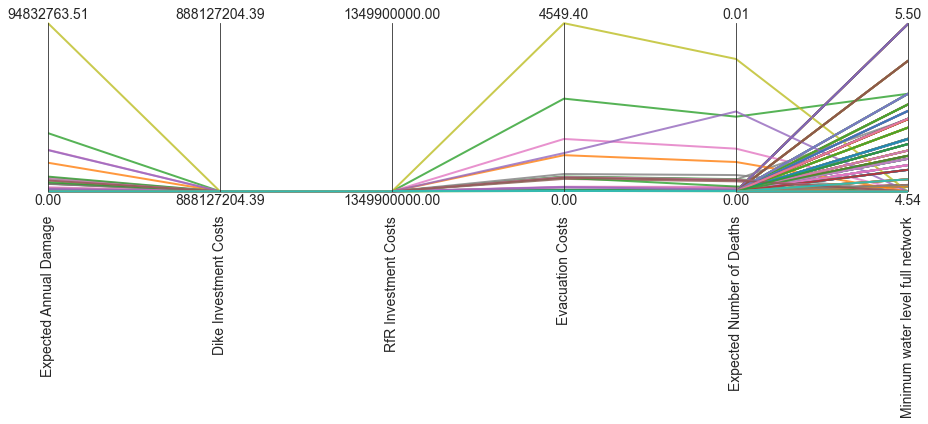

In [4]:
# Plot the outcomes of the best run over 1000 scenarios
limits = parcoords.get_limits(best_pol)
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['figure.figsize'] = (13,6)
axes = parcoords.ParallelAxes(round(limits,2))
axes.plot(best_pol, alpha = 0.8)

plt.show()

In [6]:
# Calculate robustness metrics

def hurwitz(data,column_names,alpha=0):
    '''weighs off the best and worst payoffs'''
    results = {}
    
    for column_name in column_names:
        Max_value = data[column_name].max()
        Min_value = data[column_name].min()
        
        #calculate hurwitz coefficient as described in Arrow (1972)
        if column_name != 'Minimum water level full network':
            #for minimized values, the lowest value is the best and highest is the worst
            hurwitz_coef = alpha * Min_value + (1-alpha) * Max_value
            results[column_name] = hurwitz_coef
        else:
            #for maximized values, the lowest value is the worst and highest is the best
            hurwitz_coef = alpha * Max_value + (1-alpha) * Min_value
            results[column_name] = hurwitz_coef
    
    return results

def mean_variance(data,column_names):
    '''for miminalisation this is defined as the mean times the standard deviation (Kwakkel et al, 2019)'''
    '''for maximization this is defined as the mean divided by the standard deviation (Kwakkel et al, 2019)'''
    results = {}
    
    for column_name in column_names:
        if column_name == 'Minimum water level full network':
            mean_value = data[column_name].mean()
            std_value = data[column_name].std()
            if abs(std_value) < 0.001:
                mv_coef = 0
            else:
                mv_coef = round(mean_value/std_value, 3)
            results[column_name] = mv_coef
    
        else:
            mean_value = data[column_name].mean()
            std_value = data[column_name].std()                
            mv_coef = round(mean_value*std_value, 3)
            results[column_name] = mv_coef
    
    return results

def quartile_skewedness(data,column_names):
    '''returns the quartile that contains the most observations'''
    results = {}
    Values = {}
    for column_name in column_names:
        #place all results in four equally spaced bins
        data['MyQuantileBins'] =  pd.cut(data[column_name], 4)
        values = data['MyQuantileBins'].value_counts()
        Values[column_name] = values
        #determine which quartile (bin) is overrepresented (contains the most values)
        for i in range(3):
            if max(values) == values[i]:
                #save the quartile and the percentage of values it contains in a dictionary
                results[column_name] = (i+1,(round(values[i]/values.sum(),3)))    
    return results, Values

In [7]:
# Plotting of the metrics

# This function makes a dict of hurwitz values of alpha=0,0.5,1 for each column and then plots the dict
def hurwitz_results(results,objectives,rd1,rd2,rd3,rd4,rd5):
    hurlist = [hurwitz(results,objectives,0),hurwitz(results,objectives,0.5),hurwitz(results,objectives,1)]
    hurlistrd1 = [hurwitz(rd1,objectives,0),hurwitz(rd1,objectives,0.5),hurwitz(rd1,objectives,1)]
    hurlistrd2 = [hurwitz(rd2,objectives,0),hurwitz(rd2,objectives,0.5),hurwitz(rd2,objectives,1)]
    hurlistrd3 = [hurwitz(rd3,objectives,0),hurwitz(rd3,objectives,0.5),hurwitz(rd3,objectives,1)]
    hurlistrd4 = [hurwitz(rd4,objectives,0),hurwitz(rd4,objectives,0.5),hurwitz(rd4,objectives,1)]
    hurlistrd5 = [hurwitz(rd5,objectives,0),hurwitz(rd5,objectives,0.5),hurwitz(rd5,objectives,1)]
    
    for i in objectives:
        metric = {}
        counter = 0
        for j in hurlist:
            metric['Alpha = ' + str(counter)] = j[i]
            counter += 0.5
        metricrd1 = {}
        counter = 0
        for j in hurlistrd1:
            metricrd1['Alpha = ' + str(counter)] = j[i]
            counter += 0.5
        metricrd2 = {}
        counter = 0
        for j in hurlistrd2:
            metricrd2['Alpha = ' + str(counter)] = j[i]
            counter += 0.5
        metricrd3 = {}
        counter = 0
        for j in hurlistrd3:
            metricrd3['Alpha = ' + str(counter)] = j[i]
            counter += 0.5
        metricrd4 = {}
        counter = 0
        for j in hurlistrd4:
            metricrd4['Alpha = ' + str(counter)] = j[i]
            counter += 0.5
        metricrd5 = {}
        counter = 0
        for j in hurlistrd5:
            metricrd5['Alpha = ' + str(counter)] = j[i]
            counter += 0.5
        X_axis = np.arange(3)
        
        if i != 'Minimum water level full network':
            plt.title('Results Hurwitz, {} (lower is better, Moro-robust policy in green)'.format(str(i)))
        else:
            plt.title('Results Hurwitz, {} (higher is better, Moro-robust policy in green)'.format(str(i)))
        
        plt.bar(X_axis, list(metric.values()), align='center', color = 'seagreen',width = 0.1)
        plt.bar(X_axis, list(metricrd1.values()), align='center', color = 'grey',width = 0.1)
        plt.bar(X_axis, list(metricrd2.values()), align='center', color = 'grey',width = 0.1)
        plt.bar(X_axis, list(metricrd3.values()), align='center', color = 'grey',width = 0.1)
        plt.bar(X_axis, list(metricrd4.values()), align='center', color = 'grey',width = 0.1)
        plt.bar(X_axis, list(metricrd5.values()), align='center', color = 'grey',width = 0.1)
        plt.xticks(range(len(metric)), list(metric.keys()))
        plt.show()

# This function plots the results of the mean variance metric
def mean_variance_results(results,objectives,rd1,rd2,rd3,rd4,rd5):
    Mv = mean_variance(results,objectives)
    mvrd1 = mean_variance(rd1,objectives)
    mvrd2 = mean_variance(rd2,objectives)
    mvrd3 = mean_variance(rd3,objectives)
    mvrd4 = mean_variance(rd4,objectives)
    mvrd5 = mean_variance(rd5,objectives)
    
    for i in objectives:
        plt.title('Results Mean variance:'+i)
        polaxis = ['random1', 'random2', 'random3', 'random4', 'random5']
        polvals = [mvrd1[i],mvrd2[i],mvrd3[i],mvrd4[i],mvrd5[i]]
        bestaxis = ['best']
        plt.bar(bestaxis, Mv[i], label = 'best policy', color = 'seagreen')
        plt.bar(polaxis,polvals, label = 'random', color = 'grey')
        
        plt.xticks([])

        plt.legend()
        plt.yscale('log')
        plt.show()

# This function plots the results of the quartile skewness metric
def quartile_skewedness_results(results,objectives,policy_nr,rd1,rd2,rd3,rd4,rd5):
    Qs, Qsval = quartile_skewedness(results,objectives)
    Qsrd1, Qsvalrd1 = quartile_skewedness(rd1,objectives)
    Qsrd2, Qsvalrd2 = quartile_skewedness(rd2,objectives)
    Qsrd3, Qsvalrd3 = quartile_skewedness(rd3,objectives)
    Qsrd4, Qsvalrd4 = quartile_skewedness(rd4,objectives)
    Qsrd5, Qsvalrd5 = quartile_skewedness(rd5,objectives)
    
    for i in objectives:
        
        X_axis = np.array([1,2,3,4])
        
        bins =[''] +  [str(Qsval[i].index[j]) for j in range(4)]
        plt.xticks(range(len(bins)), bins, ha='right')
        
        plt.bar(X_axis - 0.25,Qsval[i],0.1,label = 'best pol', color = 'seagreen')
        plt.bar(X_axis - 0.15,Qsvalrd1[i],0.1,label = 'random', color = 'grey')
        plt.bar(X_axis - 0.05,Qsvalrd2[i],0.1,label = 'random', color = 'grey')
        plt.bar(X_axis + 0.05,Qsvalrd3[i],0.1,label = 'random', color = 'grey')
        plt.bar(X_axis + 0.15,Qsvalrd4[i],0.1,label = 'random', color = 'grey')
        plt.bar(X_axis + 0.25,Qsvalrd5[i],0.1,label = 'random', color = 'grey')
        #Qsval[i].plot(X_axis - 0.25,kind='bar', color = 'seagreen', width = 0.1)
        #Qsvalrd1[i].plot(X_axis - 0.15,kind='bar', color = 'steelblue', width = 0.1)
        plt.xticks(rotation = 20 ,ha='right')
        plt.title('Results quartile skewedness, {}'.format(i)+ '. Q{} dominant ({}%)'.format(Qs[i][0],Qs[i][1]*100))
        plt.show()

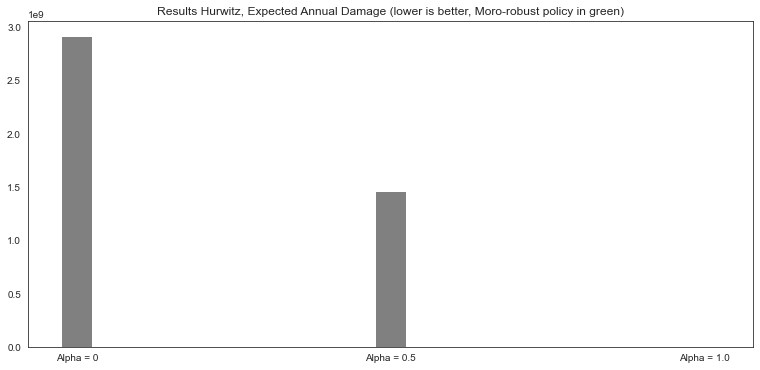

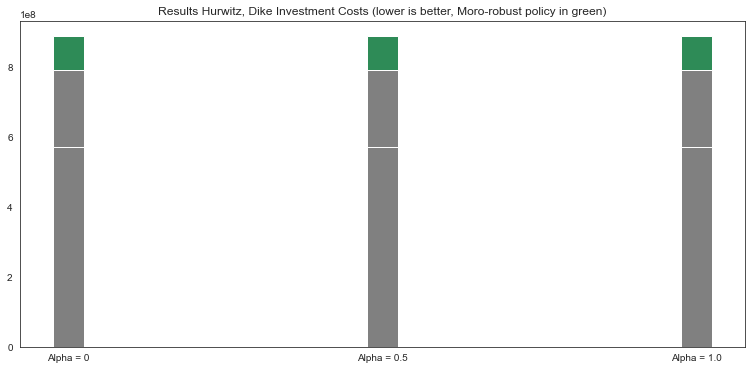

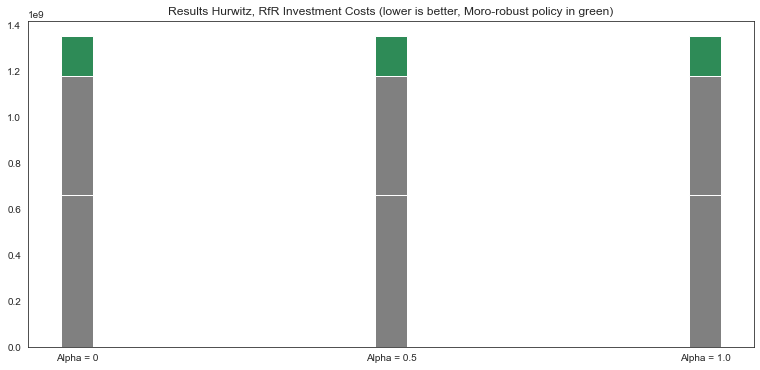

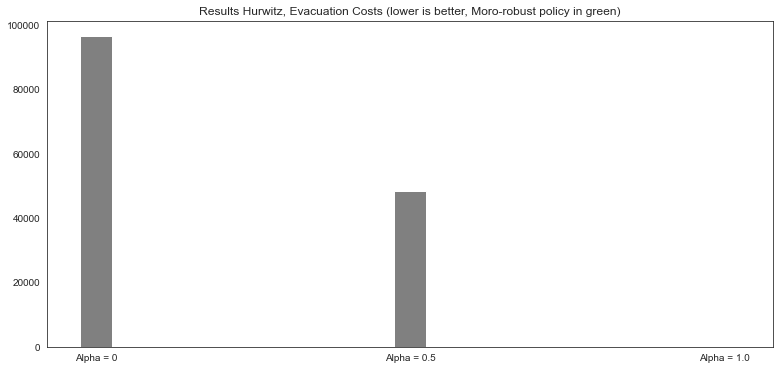

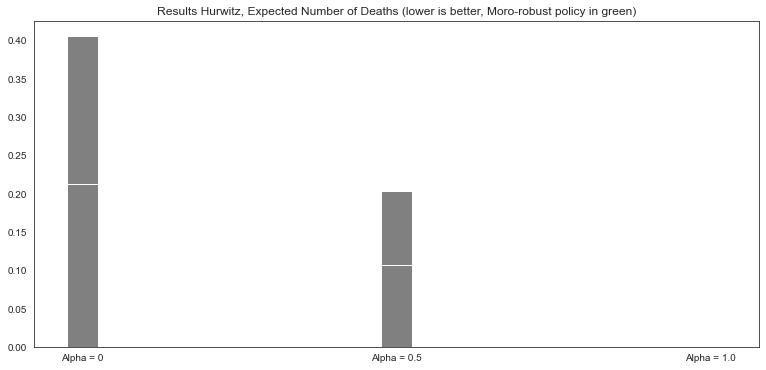

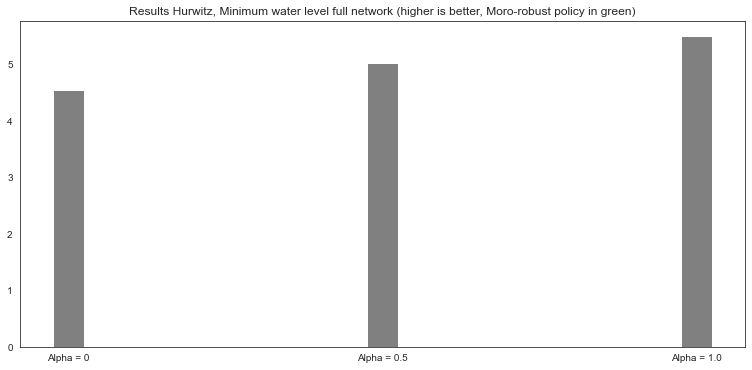

In [8]:
hurwitz_results(best_pol,objectives,rd_pol1,rd_pol2,rd_pol3,rd_pol4,rd_pol5)

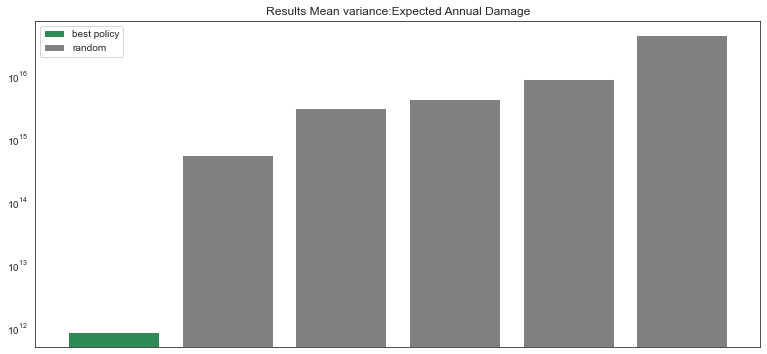

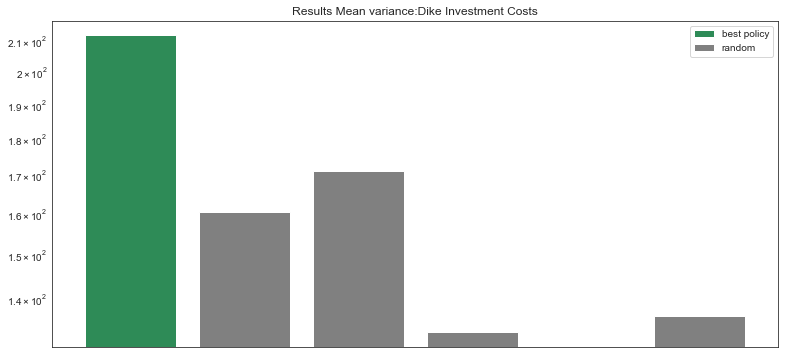

<ipython-input-7-f255dd1073ee>:79: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


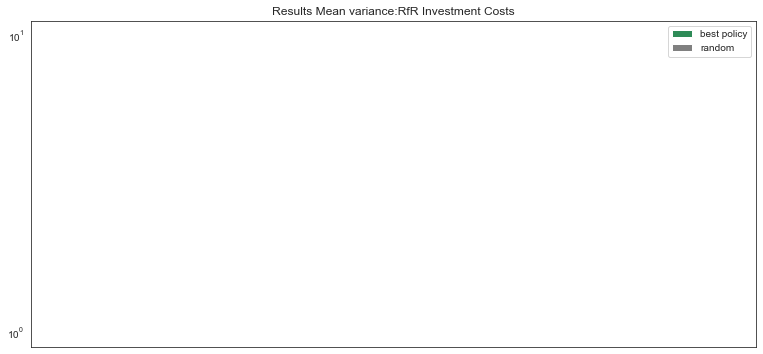

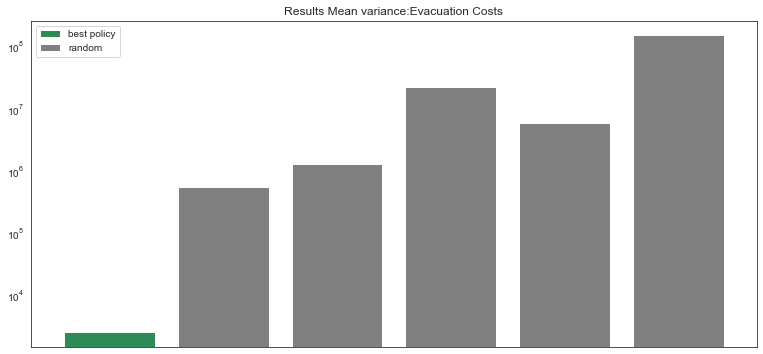

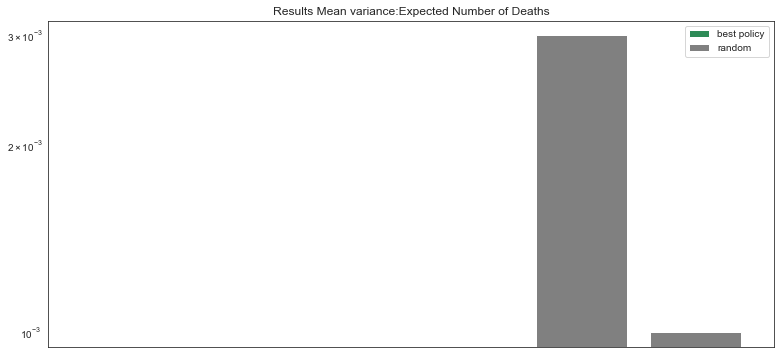

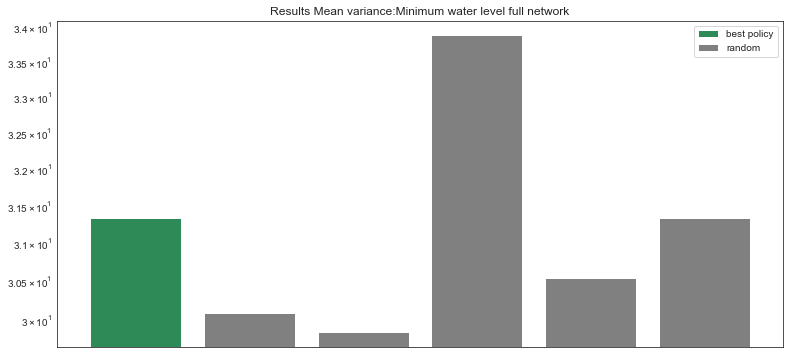

In [9]:
mean_variance_results(best_pol,objectives,rd_pol1,rd_pol2,rd_pol3,rd_pol4,rd_pol5)

<ipython-input-6-46058545e195>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['MyQuantileBins'] =  pd.cut(data[column_name], 4)


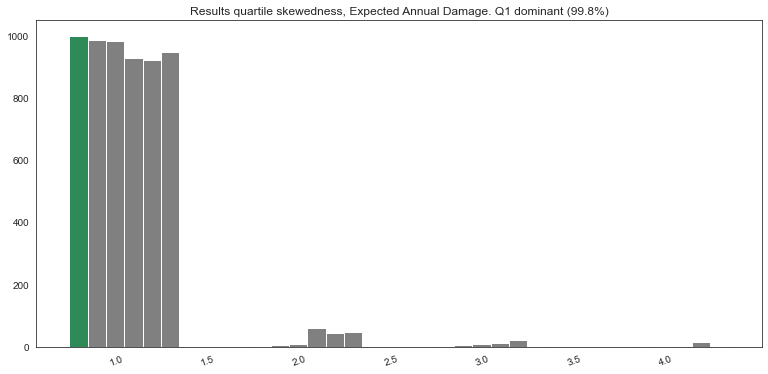

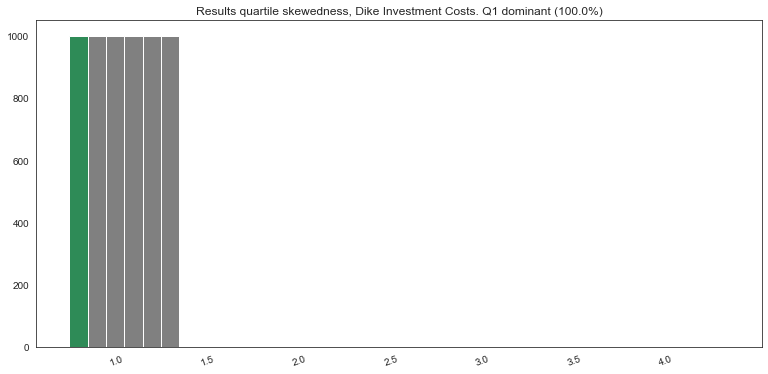

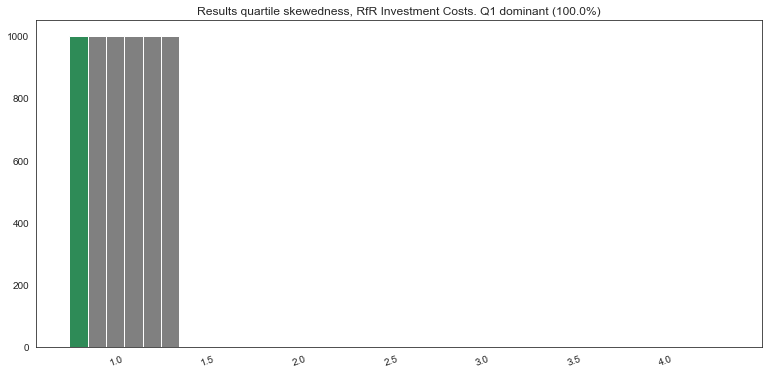

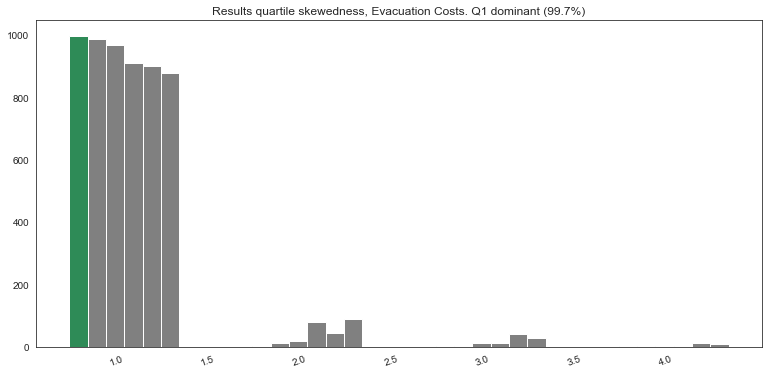

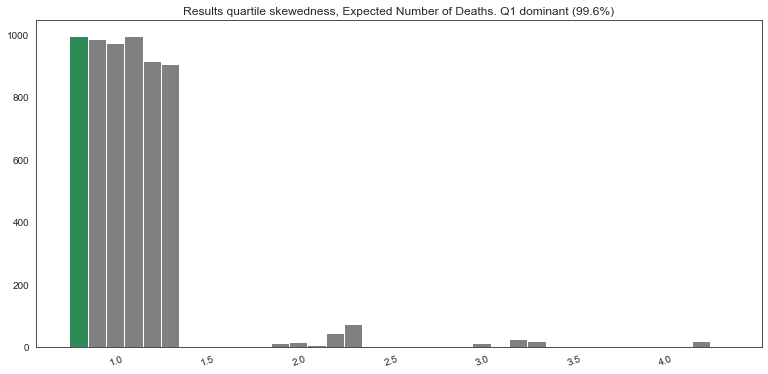

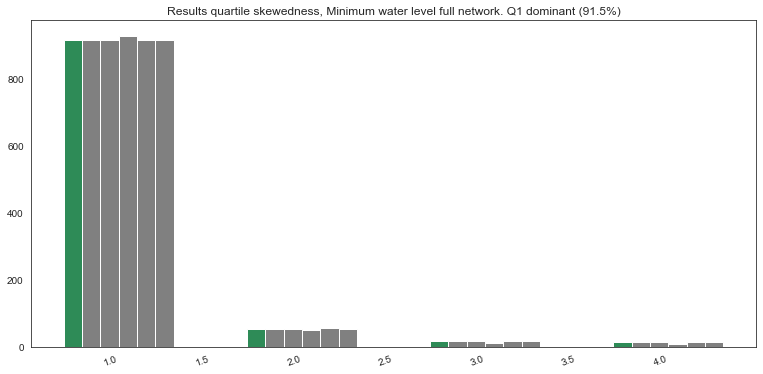

In [10]:
quartile_skewedness_results(best_pol,objectives,rd_pol1,rd_pol2,rd_pol3,rd_pol4,rd_pol5)